# ***Car Prediction Model using Mobilenet***
This code aims to create and train model for car prediction. Here the transfer learning technique is used create the model. 

**Libraries**

In [ ]:
#Imporatant Libraries for working with arrays.
import numpy as np

#Imporatant Libraries for File handling.
from glob import glob

#Important Libraries for visulization of the results.
import matplotlib.pyplot as plt

#Important Libraries for training and testing of the model.
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input


**Model Generator**

In [ ]:
def Model_Generator(IMAGE_SIZE):
  #Mobilenet architecture.
  model = MobileNet(input_shape= [IMAGE_SIZE[0], IMAGE_SIZE[1], 3], weights='imagenet', include_top=False)

  #Setting layers non trainable 
  for layer in model.layers[:-23]:
      layer.trainable = False
  
  #To get the information about all car classes.
  folders = glob('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/training/*')

  x = Flatten()(model.layers[-6].output)
  prediction = Dense(len(folders), activation='softmax')(x)

  #Complete Model.
  model = Model(inputs = model.input, outputs = prediction)
  
  #Printting Information about the model.
  print(model.summary())
  return model

**Optimizer generator**

In [ ]:
def Optimizer_Generator():
  # Set the parameters value for optimizer
  adam=tf.keras.optimizers.Adam(
          learning_rate=1e-5,
          beta_1=0.9,
          beta_2=0.999,
          epsilon=1e-07,
          decay = 0.0
  )
  return adam

**Model training**

In [ ]:
def Model_training(training_set, test_set, callback):
  results = model.fit(
                        training_set,
                        validation_data=test_set,
                        epochs=100,
                        steps_per_epoch=len(training_set),
                        validation_steps=len(test_set),
                        callbacks = [callback]
                      )
  return results

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 114, 114, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 114, 114, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 114, 114, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 114, 114, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 114, 114, 32)      0   

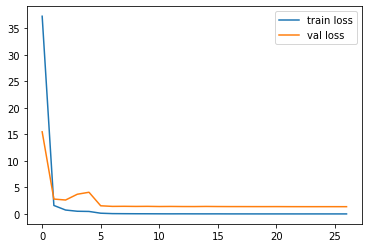

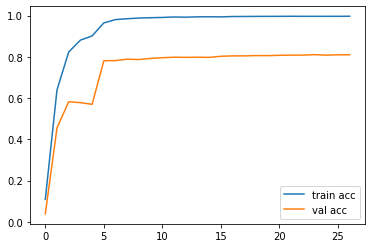

16/16 [==============================] - 11s 681ms/step - loss: 1.3738 - accuracy: 0.8100


[1.373832106590271, 0.8100000023841858]

In [ ]:
#Dimension of input image.  
Image_Dimension = [227,227]

#Generation of the model
model = Model_Generator(Image_Dimension)

#Generation of the optimizer
adam = Optimizer_Generator()

#Compile model.
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

#Generating flow from the directories for training and testing dataset.

#Genrating flow of images from training dataset.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range = 0,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/training',
                                                 target_size = (227, 227),
                                                 batch_size = 256,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

#Genrating flow of images from testing dataset.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/testing',
                                            target_size = (227, 227),
                                            batch_size = 256,
                                            class_mode = 'categorical',
                                            shuffle=True)

#Set Callback options here.
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Project/sample/./weights.{epoch:02d}.hdf5'
callback = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4,mode = 'auto', restore_best_weights=False),
            tf.keras.callbacks.CSVLogger('traininglog.csv', separator=",", append=False),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=2, mode="auto",min_delta=0.0001,min_lr=0),
            tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True),
           ]


results = Model_training(training_set, test_set, callback)

#Visualizing the results.

#Plot for epoch versus loss.
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.legend()
plt.show()

#Plot for epoch versus accuracy.
plt.plot(results.history['accuracy'], label='train acc')
plt.plot(results.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
 
#Save model 
model.save('/content/drive/MyDrive/Colab Notebooks/Project/Cars100/New_model.h5')
